In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn

## The toy experiment
The ATLAS detector and the physics involved are insanely complicated. We will make our life easier by designing a toy project to explore ideas in a controlled environment.

### The problem
A scientist is faced with a strange challenge she has recieved from her eccentric colleague in the robotics-department. He has given her a big box which she can not open. It is supplied with electricity and is mounted on a table. The rules of the challenge state that she may interact with it only in very limited ways:

- There is a screen showing an xy-coordinate system. She can record any position on this screen by any means she wants.
- There are two big buttons which can light up. One is red and one is green. If she pushes one of the buttons, a red dot appears on the screen in what appears to be a new location each time.
- There is another button with the text ´start simulation´. If she pushes this button one of the two colors light up and then a red dot appears on the screen. This is repeated 100 times. If she pushes it again a new sequence appears.

As she is a scientist she believes that she should be able to at least figure _something_ out about this machine by exploring the statistical properties of the observed output.

Her eccentric friend has said that if she can make a fair estimate of the probabilistic mathematical relationship between the color which lights up and the coordinate which is shown she has won the first part of the challenge. He gives her a few hints:

- The relationship between the color and the coordinates is non-deterministic, but there is a logical relationship where color implies coordinate.
- Pressing the simulation-button produces output which are all drawn from the same distribution and is not ordered. Each run is exchangeable and each individual set of color-coordinate pairs is exchangeable.
- Pressing a color button gives us a way to decide the color and sample from the coordinate-distribution of that color.



### The robot
Inside the box there is a two-joint robot-arm which draws points on a surface. The position the robot reaches is decided by the parameters $R_1$, $R_2$, $\theta_1$ and $\theta_2$, indicating the length of the first and second rod and the angle of the joints.


$(\theta_1, \theta_2, R_1, R_2) \rightarrow (x, y) = (R_1 \cos(\theta_1) + R_2 \cos(\theta_1 + \theta_2), R_1 \sin(\theta_1) + R_2 \sin(\theta_1 + \theta_2))$

The robot-creator has added randomness to the problem by distributing all four parameters according to the color:

#### Red
$R_1 = N(\mu_{1, red}, \sigma)$

$R_2 = const$

$\theta_1 = Uniform(0, 2\pi)$

$\theta_2 = Uniform(0, \pi)$

#### Green
$R_1 = N(\mu_{1, green}, \sigma)$
$R_2 = const$
$\theta_1 = Uniform(0, 2\pi)$
$\theta_2 = Uniform(0, \pi)$


### The experiment

It takes a long time to manually record the results, and she has other things to do so she wants to minimize the time she spends on this experiment. Still, she asks her master students to spend some hours collecting a fair amount of data. To get the probabilities which quantify how fast she is learning, she uses the process of Bayesian inference to update her knowledge. But these calculations take a long time, so she can't use all the data they gathered, and the uncertainties are large... She would like to figure out if machine learning can help her in this project.

In [37]:
def robot_arm(theta1, theta2, r1, r2):
    ya = r1*np.cos(theta1) + r2*np.cos(theta1 + theta2)
    yb = r1*np.sin(theta1) + r2*np.sin(theta1 + theta2)
    return ya, yb

In [38]:
# CONSTANTS
R_1 = [6, 4]
R_2 = 3
rng = np.random.default_rng()

Text(0, 0.5, 'x2')

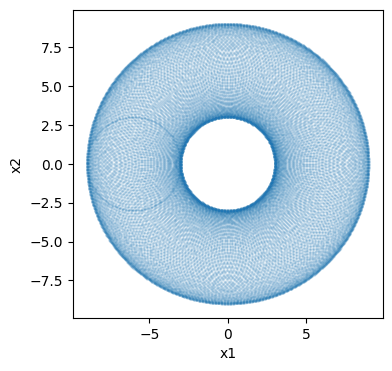

In [39]:
# Look at the mapping function for constant R
nx = 200
#angles
a1 = np.linspace(-np.pi, np.pi, nx)
a2 = np.linspace(-np.pi, np.pi, nx)

aa1, aa2 = np.meshgrid(a1, a2)

xx1, xx2 = robot_arm(aa1, aa2, R_1[0], R_2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4))

ax.scatter(xx1, xx2, s=1, alpha=0.1)
ax.set_xlabel("x1")
ax.set_ylabel("x2")

Text(0, 0.5, 'x1')

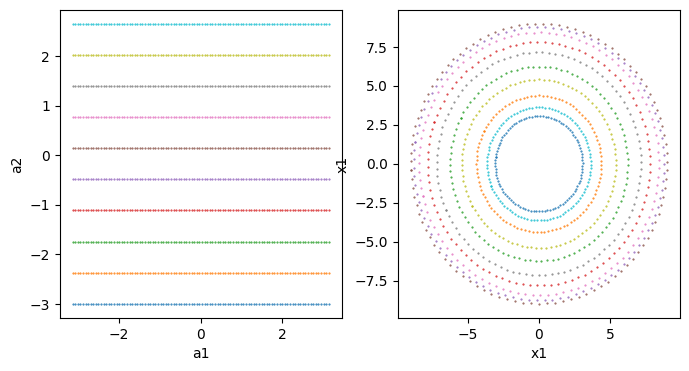

In [40]:
# Look at the mapping function for constant theta2
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a1 = np.linspace(-np.pi, np.pi, na)
for i in range(lines):
    da2 = 2*np.pi/lines
    a2 = 0*a1 -3 + i*da2
    x1, x2 = robot_arm(a1, a2, R_1[0], R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

Text(0, 0.5, 'x1')

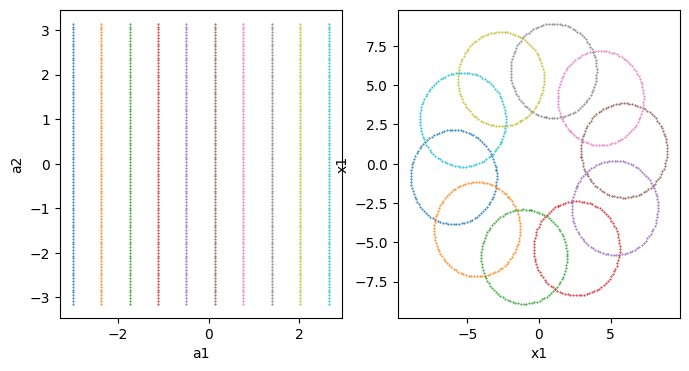

In [41]:
# Look at the mapping function for constant theta1
na = 100

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
a2 = np.linspace(-np.pi, np.pi, na)
for i in range(lines):
    da1 = 2*np.pi/lines
    a1 = 0*a2 -3 + i*da1
    x1, x2 = robot_arm(a1, a2, R_1[0], R_2)
    ax[0].plot(a1, a2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(x1, x2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("a1")
ax[0].set_ylabel("a2")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x1")

In [42]:

# Generate a very long run datasample

def gen_data(n):
    df_keys = ["color", "x1", "x2", "a1", "a2", "r1", "r2"]

    for i, c in enumerate(["red", "green"]):
        df_temp = pd.DataFrame(columns=df_keys)
        r1 = np.random.normal(R_1[i], 0.3, n)
        r2 = r1*0 + R_2
        df_temp["r1"] = r1
        df_temp["r2"] = r2
        a1 = np.array([random.uniform(0, 2*np.pi) for i in range(n)])
        a2 = np.array([random.uniform(0, np.pi) for i in range(n)])
        df_temp["a1"] = a1
        df_temp["a2"] = a2

        # Get robot arm value
        x1, x2 = robot_arm(a1, a2, r1, r2)
        df_temp["x1"] = x1
        df_temp["x2"] = x2
        df_temp["color"] = c

        if i==0:
            df = df_temp
        else:
            df = pd.concat([df, df_temp])
    
    return df

df_many = gen_data(10000)

In [43]:
df_many

,color,x1,x2,a1,a2,r1,r2
0,red,3.457065,-7.754572,4.829573,1.001425,6.488268,3.0
1,red,8.640460,-1.134204,6.142719,0.028895,5.715404,3.0
2,red,-2.834275,-4.104065,3.596962,2.192101,6.096692,3.0
3,red,-2.691929,7.985946,1.603675,0.942992,6.308012,3.0
4,red,6.153144,1.393098,6.012736,1.666179,5.843012,3.0
...,...,...,...,...,...,...,...
9995,green,-2.855811,5.085234,1.603165,1.111987,3.846350,3.0
9996,green,-0.249702,-2.429438,3.899963,2.582229,4.394872,3.0
9997,green,1.591246,2.912788,0.240514,2.186035,3.970735,3.0
9998,green,1.725748,-0.268560,5.136295,2.632355,3.573980,3.0


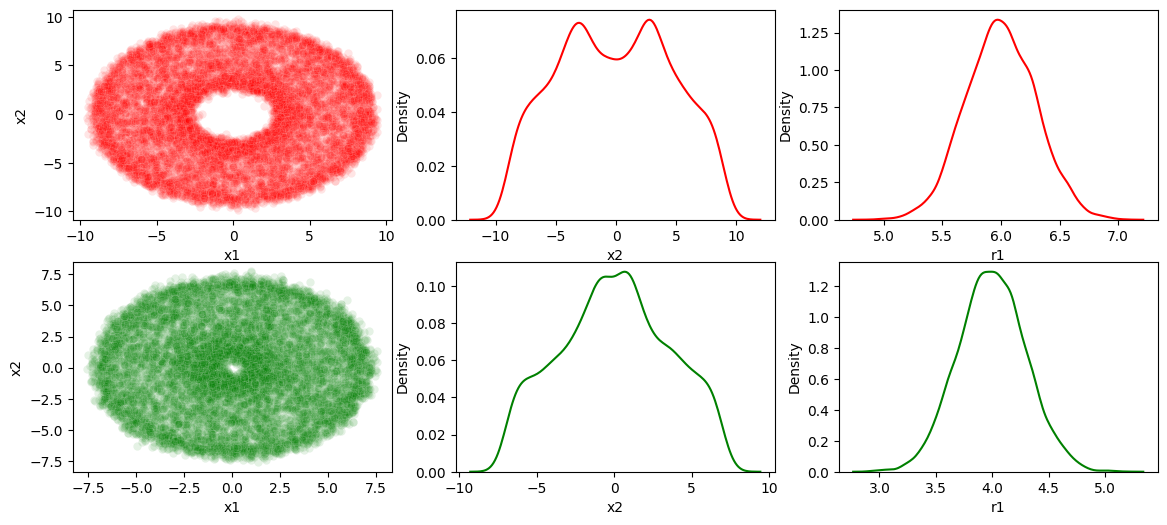

In [44]:
def plot_data(df):

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 6))

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.kdeplot(df_red, x="x2", c="red", ax=ax[0][1])
    sn.kdeplot(df_red, x="r1", c="red", ax=ax[0][2])

    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
    sn.kdeplot(df_green, x="x2", c="green", ax=ax[1][1])
    sn.kdeplot(df_green, x="r1", c="green", ax=ax[1][2])

    return fig, ax

fig, ax = plot_data(df_many)

In [45]:
# Generate training data
df_cal = gen_data(200)
df_train = gen_data(2000)

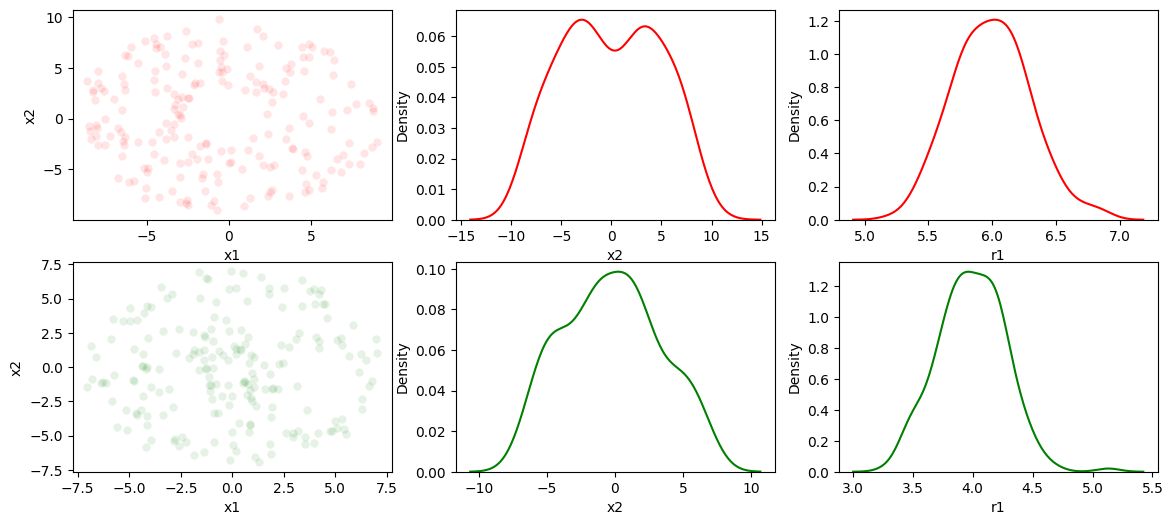

In [46]:
fig, ax = plot_data(df_cal)

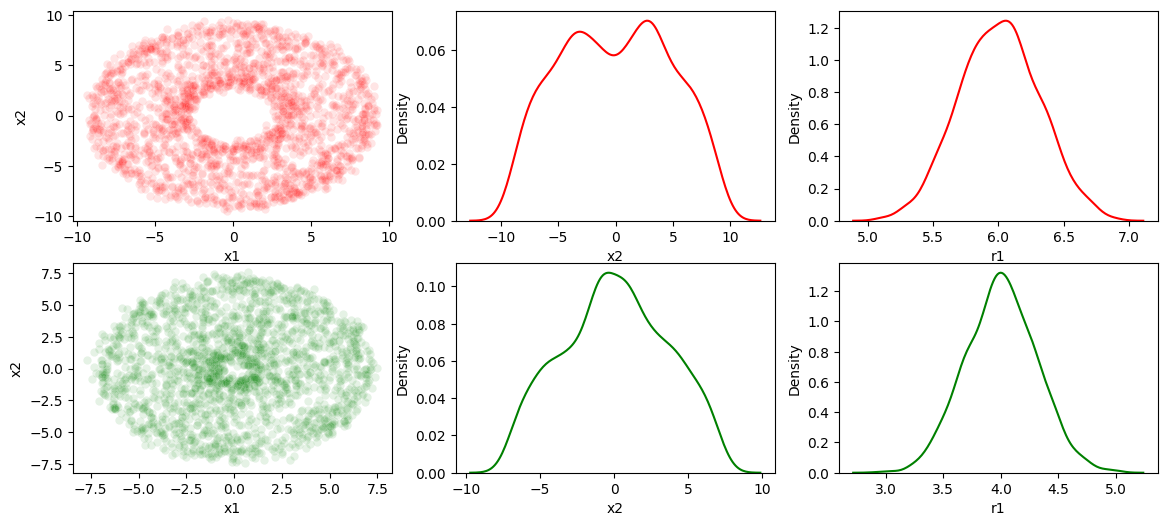

In [50]:
df_test = gen_data(2000)
fig, ax = plot_data(df_test)

In [51]:
df_test

,color,x1,x2,a1,a2,r1,r2
0,red,1.341472,3.609887,0.936304,2.780660,6.509191,3.0
1,red,-1.844976,-2.824356,4.124399,3.131087,6.373249,3.0
2,red,2.590663,0.900639,6.234372,2.792557,5.362741,3.0
3,red,-4.298688,-5.823602,3.650817,1.485553,6.336870,3.0
4,red,5.014262,2.695111,6.271868,1.980527,6.178527,3.0
...,...,...,...,...,...,...,...
1995,green,-0.711010,-4.083529,3.790699,1.915773,4.049321,3.0
1996,green,4.749725,-1.654297,5.308945,1.576343,4.053577,3.0
1997,green,-0.213931,0.897053,1.364783,3.010246,3.808482,3.0
1998,green,-4.819299,4.817999,2.251879,0.239103,3.862808,3.0


In [52]:
# Save data
df_train.to_csv("data/train.csv", index=False)
df_cal.to_csv("data/cal.csv", index=False)
df_test.to_csv("data/test.csv", index=False)